## Dataloader

In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightning as L
import torchaudio.transforms as T
from transformers import Wav2Vec2Model
from module.KAN import KAN
from metrix.LM import LandmarkDistance, LandmarkVelocityDifference
import torchaudio


/mnt/e/ws/2024/S2T/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
import torchaudio.transforms as T


class MEAD(Dataset):
    def __init__(self, data_path, duration, batch):
        super(MEAD, self).__init__()

        with open(data_path,"r") as f:
            datalist = json.load(f)
        ln = int(len(datalist)/batch)*batch
        self.datalist = datalist[:ln]
        self.time = duration

        self.mn = 56
        self.mx = 243



    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, idx):
        row = self.datalist[idx]

        waveform, sample_rate = torchaudio.load(f"dataset/duration/audios/{row['audio']}", num_frames= 48000* self.time, normalize="True")
        landmark =  torch.from_numpy(np.load(f"dataset/duration/fa_landmarks/{row['landmark']}")).permute(0,2,1)[:30*self.time]
        landmark = (landmark - self.mn) / (self.mx - self.mn)
        # ilm = torch.mean(landmark, dim=1)
        name = row["name"].split('_')[0]
        ilm = landmark[0]
        waveform = T.Resample(48000, 16000, dtype=waveform.dtype)(waveform)
        waveform = torch.mean(waveform, dim=0)

        # waveform = torch.load(f"dataset/vec2s/M003_front_{row['name']}.pt")

        return {'name': row['name'], 'audio':waveform.float(), 'target':landmark.float(), 'ilm':ilm.float(), 'label':row['emotion']}

## Module


In [11]:
import torch
import torch.nn as nn
import torchaudio
import pytorch_lightning as L

class Transformer(L.LightningModule):
    def __init__(self, in_c, out_c, nhead, num_lay=2, sub_chanel=49,):
        super(Transformer, self).__init__()

        torch.autograd.set_detect_anomaly(True)

        en_lay = nn.TransformerEncoderLayer(d_model=in_c, nhead=nhead, dropout=0.2)
        self.transformer_encoder = nn.Sequential(
            nn.TransformerEncoder(en_lay, num_layers=num_lay),
            nn.Linear(in_features=in_c, out_features=out_c*2)
        )
        de_lay = nn.TransformerDecoderLayer(d_model=out_c*2, nhead=nhead, dropout=0.2)
        self.transformer_decoder = nn.TransformerDecoder(de_lay, num_layers=num_lay)
        self.conv = nn.Conv1d(1, sub_chanel, 1,1)

    def forward(self, x, v):
        x = self.transformer_encoder(x)
        v = self.conv(v)
        x = self.transformer_decoder(v, x)
        return x


class S2LM(L.LightningModule):
    def __init__(self, batch, init_lr, num_of_landmarks=478):
        super(S2LM, self).__init__()

        torch.autograd.set_detect_anomaly(True)

        self.MOUTH_LANDMARKS = [49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 48]
        self.init_lr = init_lr
        self.batch = batch
        self.loss = nn.MSELoss()
        self.LD = LandmarkDistance()
        self.LVD = LandmarkVelocityDifference()
        self.w2v = torchaudio.pipelines.WAV2VEC2_BASE.get_model()
        self.w2v.eval()
        for param in self.w2v.parameters():
            param.requires_grad = False

        self.trans_ct = Transformer(in_c=768, out_c=num_of_landmarks, nhead=1, num_lay=1)
        self.trans_gb = Transformer(in_c=768, out_c=num_of_landmarks, nhead=2, num_lay=1)
        self.trans_gbm = Transformer(in_c=768, out_c=len(self.MOUTH_LANDMARKS), nhead=2, num_lay=1)

        self.lstm = nn.LSTM(input_size=768, hidden_size=68, num_layers=1, batch_first=True, bidirectional=True, dropout=0.3)
        self.mouth = nn.LSTM(input_size=768, hidden_size=len(self.MOUTH_LANDMARKS), num_layers=1, batch_first=True, bidirectional=True, dropout=0.3)

        self.R1 = nn.Sequential(
            nn.Conv2d(147, 256, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 1, 1),
            nn.ReLU(),
            nn.Conv2d(256, 30, 3, 1, 1)
        )
        self.R2 = nn.Sequential(nn.Conv2d(147, 30, 1, 1))
                                
        self.R3 = nn.Sequential(
            nn.Conv2d(98, 128, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 1, 1),
            nn.ReLU(),
            nn.Conv2d(128, 30, 3, 1, 1)
        )
        self.KAN = KAN([68, 512, 68])

    def forward(self, x, v, w):

        x = self.w2v(x)[0]
        vm = v[:,:,self.MOUTH_LANDMARKS].view(self.batch, 1, -1)
        v = v.view(self.batch, 1, -1)
        gbm = self.trans_gbm(x, vm)
        gb = self.trans_gb(x, v)

        with torch.no_grad():
            w = nn.functional.softmax(w.float(), dim=0)
            w = w[:, None, None]
            x = torch.mul(x, w)

        f = self.lstm(x)[0]
        m = self.mouth(x)[0]
        x = self.trans_ct(x, v)

        x = torch.cat([f, gb, x], dim=1)
        m = torch.cat([m, gbm], dim=1)

        x = x.view(self.batch, -1, 2, 68)
        m = m.view(self.batch, -1, 2, 20)


        m = self.R3(m)
        t = self.R2(x)
        x = self.R1(x)
        x *= t
        x[:, :, :, self.MOUTH_LANDMARKS] = m
        y = self.KAN(x)
        
        return y

    def training_step(self, batch, batch_idx):
        x = batch['audio']
        y = batch['target']
        v = batch['ilm']
        w = batch['label']
        y_ = self.forward(x, v, w)
        tt_loss = self.loss(y_.float(), y.float())
        m_loss = self.loss(y_[:, :, :, self.MOUTH_LANDMARKS].float(), y[:, :, :, self.MOUTH_LANDMARKS].float())
        loss = tt_loss * 0.2 + m_loss * 0.8
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch['audio']
        y = batch['target']
        v = batch['ilm']
        w = batch['label']

        y_ = self.forward(x, v, w)
        loss = self.loss(y_.float(), y.float())
        ld = self.LD(y_, y)
        lvd = self.LVD(y_, y)
        ldm = self.LD(y_[:,:, :,self.MOUTH_LANDMARKS], y[:,:, :, self.MOUTH_LANDMARKS])
        lvdm = self.LVD(y_[:,:, :,self.MOUTH_LANDMARKS], y[:,:, :, self.MOUTH_LANDMARKS])
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('ld', ld, on_epoch=True, prog_bar=True, logger=True)
        self.log('lvd', lvd, on_epoch=True, prog_bar=True, logger=True)
        self.log('ldm', ldm, on_epoch=True, prog_bar=True, logger=True)
        self.log('lvdm', lvdm, on_epoch=True, prog_bar=True, logger=True)


        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.init_lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0.00001)
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss_epoch'
        }


In [12]:
datas = MEAD("dataset/duration/datalist_lv3_M030.json", duration=1, batch=16)
trainsize = int(len(datas) * (90 /100) / 16) * 16
testsize = len(datas) - trainsize
train_dataset, test_dataset = torch.utils.data.random_split(datas, [trainsize, testsize])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False,  num_workers=16)

model = S2LM(batch=16, init_lr=3e-4, num_of_landmarks=68)
# model = S2LM.load_from_checkpoint(",batch=16, init_lr=3e-4, num_of_landmarks=68)


In [8]:
torch.set_float32_matmul_precision("high")
trainer = L.Trainer(max_epochs=200, default_root_dir="weights", fast_dev_run=False, check_val_every_n_epoch=1)
trainer.fit(model, train_dataloader, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type          | Params | Mode 
-----------------------------------------------------
0  | loss      | MSELoss       | 0      | train
1  | w2v       | Wav2Vec2Model | 94.4 M | eval 
2  | trans_ct  | Transformer   | 6.3 M  | train
3  | trans_gb  | Transformer   | 6.3 M  | train
4  | trans_gbm | Transformer   | 5.7 M  | train
5  | lstm      | LSTM          | 455 K  | train
6  | mouth     | LSTM          | 126 K  | train
7  | R1        | Sequential    | 473 K  | train
8  | R2        | Sequential    | 4.4 K  | train
9  | R3        | Sequential    | 164 K  | train
10 | linear    | Sequential    | 70.2 K | train
-----------------------------------------------------
19.7 M    Trainable params
94.4 M    Non-trainable params
114 M     Total params
456.182   Total estimated model params size (MB)


Epoch 199: 100%|██████████| 448/448 [00:29<00:00, 15.25it/s, v_num=6, train_loss_step=9.34e-5, val_loss=0.000246, ld=3.990, lvd=3.480, ldm=2.520, lvdm=1.380, train_loss_epoch=0.000103] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 448/448 [00:32<00:00, 13.67it/s, v_num=6, train_loss_step=9.34e-5, val_loss=0.000246, ld=3.990, lvd=3.480, ldm=2.520, lvdm=1.380, train_loss_epoch=0.000103]


## Test


## Draw

In [13]:
# model.to("cuda")
# model.eval()
model = S2LM.load_from_checkpoint("weights/lightning_logs/240625*_200/checkpoints/epoch=199-step=28800.ckpt", batch=16, init_lr=1e-3, num_of_landmarks=68)
model.to("cuda")
model.eval()
print()

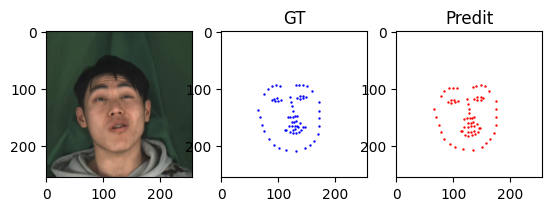

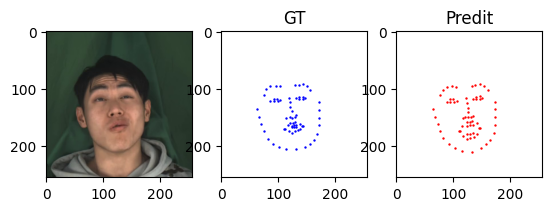

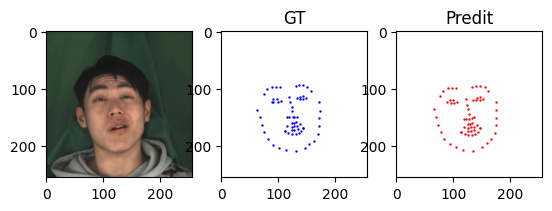

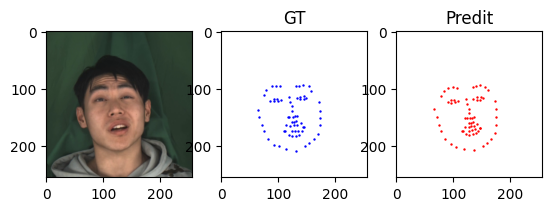

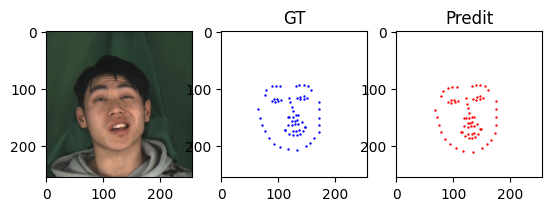

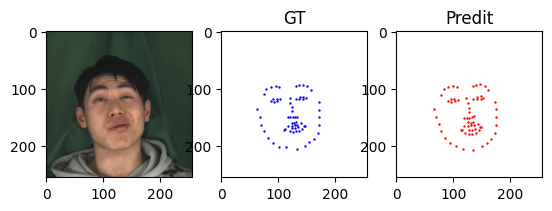

In [14]:
import torchvision
# MOUTH_LANDMARKS =[61, 76, 62, 185, 184, 183, 78, 77, 146, 191, 95, 96, 40, 74, 42, 80, 88, 89, 90, 91, 39, 73, 41, 81, 178, 179, 
#                                180, 181, 37, 72, 38, 82, 87, 86, 85, 84, 0, 11, 12, 13, 14, 15, 16, 17, 267, 302, 268, 312, 317, 316, 315, 314,
#                                  269, 303, 271, 311, 402, 403, 404, 405, 270, 304, 272, 310, 318, 319, 320, 321, 409, 408, 407, 415, 324, 325,
#                                    307, 375, 308, 292, 306, 291]


# datas = MEAD("dataset/eachsec/M030_sf/all.json", batch=64, stage='test')
# dataloader = DataLoader(datas, batch_size=64, shuffle=False,  num_workers=8)

MOUTH_LANDMARKS =[49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 48]
item = next(iter(test_dataloader))
item = next(iter(test_dataloader))
item = next(iter(test_dataloader))


x = item['audio'].to("cuda")
v = item['ilm'].to("cuda")
y = item['target'].to("cuda")
w = item['label'].to("cuda")
name = item['name'][1].split("_",1)
video = torchvision.io.read_video(f"dataset/duration/vidcrops/{name[0]}_front_{name[1]}.mp4", pts_unit='sec')[0]

y_ = model.forward(x,v,w)
y_ = y_.cpu().detach().numpy()
y = y.cpu().detach().numpy()
v = v.cpu().detach().numpy()

y = y * (datas.mx - datas.mn) + datas.mn
y_ = y_ * (datas.mx - datas.mn) + datas.mn

# y = y * (datas.mx - datas.mn) + datas.mn
# y_ = y_ * (datas.mx - datas.mn) + datas.mn


for t in range(0,len(y[1]),5):
    plain = np.ones((256,256,3))
    plt.subplot(1,3,1)
    plt.imshow(video[t])
    plain = np.ones((256,256,3))
    plt.subplot(1,3,2)
    plt.imshow(plain)
    plt.scatter(y[1][t][0,:], y[1][t][1,:], c='b', s=0.5)
    plt.title("GT")
    plt.subplot(1,3,3)
    plt.imshow(plain)
    plt.scatter(y_[1][t][0,:], y_[1][t][1,:], c='r', s=0.5)
    plt.title("Predit")
    plt.show()


array([ 0.        ,  0.        ,  0.        , ..., -0.10174523,
       -0.08038782, -0.05853514], dtype=float32)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video created: temp/video_0.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video created: temp/video_1.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video created: temp/video_2.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video created: temp/video_3.mp4


[libx264 @ 0x563e5dfa6e80] frame I:2     Avg QP:23.06  size:  7612
[libx264 @ 0x563e5dfa6e80] frame P:9     Avg QP:22.27  size:   783
[libx264 @ 0x563e5dfa6e80] frame B:25    Avg QP:23.99  size:   279
[libx264 @ 0x563e5dfa6e80] consecutive B-frames:  5.6%  5.6%  0.0% 88.9%
[libx264 @ 0x563e5dfa6e80] mb I  I16..4: 17.8% 64.6% 17.7%
[libx264 @ 0x563e5dfa6e80] mb P  I16..4:  0.1%  0.3%  0.0%  P16..4:  1.7%  1.4%  1.2%  0.0%  0.0%    skip:95.3%
[libx264 @ 0x563e5dfa6e80] mb B  I16..4:  0.0%  0.2%  0.0%  B16..8:  2.0%  0.5%  0.4%  direct: 0.2%  skip:96.7%  L0:56.9% L1:38.9% BI: 4.1%
[libx264 @ 0x563e5dfa6e80] 8x8 transform intra:65.2% inter:24.4%
[libx264 @ 0x563e5dfa6e80] coded y,u,v intra: 12.6% 7.5% 7.7% inter: 0.8% 0.3% 0.2%
[libx264 @ 0x563e5dfa6e80] i16 v,h,dc,p: 47% 49%  3%  0%
[libx264 @ 0x563e5dfa6e80] i8 v,h,dc,ddl,ddr,vr,hd,vl,hu: 35%  8% 56%  0%  0%  0%  0%  0%  0%
[libx264 @ 0x563e5dfa6e80] i4 v,h,dc,ddl,ddr,vr,hd,vl,hu: 49% 26% 10%  1%  3%  3%  3%  2%  3%
[libx264 @ 0x563e5dfa

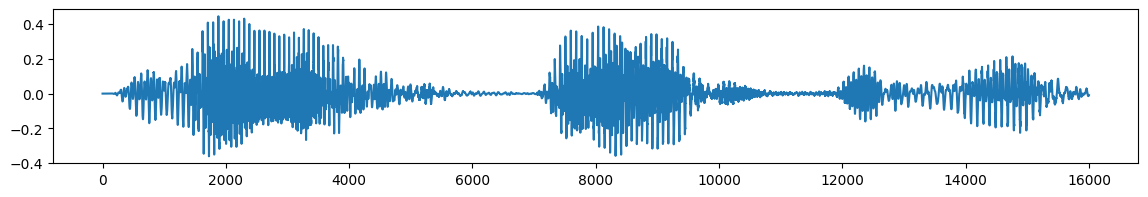

In [45]:
import subprocess
import os

for i in range(4):
    name = item['name'][i].split("_",1)
    video = torchvision.io.read_video(f"dataset/duration/vidcrops/{name[0]}_front_{name[1]}.mp4", pts_unit='sec')[0]
    os.mkdir(f"temp/out_temp/{i}")
    for t in range(len(y_[i])):
        plain = np.ones((256,256,3))
        plt.subplot(3,1,1)
        plt.imshow(video[t])
        plain = np.ones((256,256,3))
        plt.axis('off')
        plt.subplot(3,1,2)
        plt.imshow(plain)
        plt.scatter(y[i][t][0,:], y[i][t][1,:], c='b', s=0.5)
        plt.axis('off')
        plt.subplot(3,1,3)
        plt.imshow(plain)
        plt.scatter(y_[i][t][0,:], y_[i][t][1,:], c='r', s=0.5)
        plt.axis('off')
        plt.savefig(f"temp/out_temp/{i}/{t}.png")
        plt.close()
    au = x[i].cpu()
    plt.figure(figsize=(14,2))
    plt.plot(au)
    plt.savefig(f"temp/sig/{i}.png")
    torchaudio.save(f'temp/sig/{i}.wav', au.unsqueeze(0), 16000)



    image_folder = 'temp/out_temp'  # Replace with your folder path
    video_name = f'temp/video_{i}.mp4'

    command = ['ffmpeg', '-i', f'{image_folder}/%d.png',  '-r', '30', video_name, '-y']
    subprocess.run(command)
    print(f"Video created: {video_name}")

## Analysis

In [102]:
df = pd.read_json("dataset/fa_datalist.json")

FileNotFoundError: File dataset/fa_datalist.json does not exist

In [26]:
temp = df['name'].str.split('_').apply(lambda x: x[3])

In [44]:
new = new.drop(columns=['level'])

In [45]:
new.to_json('dataset/datalist_lv3.json', orient='records', index=False)